In [25]:
from pathlib import Path
from kilosort.io import load_ops
import sys
import spikeinterface as si
import matplotlib.pyplot as plt

import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics as sqm
import json
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from kilosort import io
warnings.filterwarnings('ignore')

global_job_kwargs = dict(n_jobs = 4)
si.set_global_job_kwargs(**global_job_kwargs)

In [63]:
import os
import pandas as pd
import numpy as np

def get_spike_inf(file_path):
    cluster_inf = pd.read_csv(file_path + "/analyzer_kilosort4_binary/extensions/quality_metrics/metrics.csv")
    cluster_inf.columns = ['cluster', 'num_spikes', 'firing_rate', 'presence_ratio', 'snr',
                           'isi_violations_ratio', 'isi_violations_count', 'rp_contamination',
                           'rp_violations', 'sliding_rp_violation', 'amplitude_cutoff',
                           'amplitude_median', 'amplitude_cv_median', 'amplitude_cv_range',
                           'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 'firing_range',
                           'drift_ptp', 'drift_std', 'drift_mad', 'sd_ratio']
    
    cluster_inf['cluster'] = cluster_inf['cluster'].astype(str)
    cluster_inf['position_1'] = None
    cluster_inf['position_2'] = None

    spike_clusters = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/spike_clusters.npy").astype(str))
    spike_positions = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/spike_positions.npy").astype(float))
    spike_templates = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/spike_templates.npy"))
    spike_times = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/spike_times.npy").astype(int))
    tf = pd.DataFrame(np.load(file_path + "/kilosort4/sorter_output/tF.npy")[:, 0, :])

    spike_inf = pd.concat((spike_clusters, spike_positions, spike_templates, spike_times, tf), axis=1)
    spike_inf.columns = ['cluster', 'position_1', 'position_2', 'templates', 'time', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6']

    for i in spike_inf['cluster'].value_counts().index:
        temp = spike_inf[spike_inf['cluster'] == i]
        cluster_inf.loc[cluster_inf['cluster'] == i, 'position_1'] = np.mean(temp['position_1'])
        cluster_inf.loc[cluster_inf['cluster'] == i, 'position_2'] = np.mean(temp['position_2'])

    cluster_inf['probe_group'] = "1"

    for i in spike_inf['cluster'].value_counts().index:
        cluster_rows = cluster_inf[cluster_inf['cluster'] == i]
        if (cluster_rows['position_1'] > 100).any() and (cluster_rows['position_1'] < 250).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "2"
        elif (cluster_rows['position_1'] > 250).any() and (cluster_rows['position_1'] < 400).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "3"
        elif (cluster_rows['position_1'] > 400).any() and (cluster_rows['position_1'] < 550).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "4"
        elif (cluster_rows['position_1'] > 550).any():
            cluster_inf.loc[cluster_inf['cluster'] == i, 'probe_group'] = "5"

    waveform = np.load(file_path + "/kilosort4/sorter_output/templates.npy")
    cluster_inf['waveform'] = [waveform[i] for i in range(waveform.shape[0])]

    cluster_inf = cluster_inf[((cluster_inf['snr'] > 3) & (cluster_inf['num_spikes'] > int(5000))) | ((cluster_inf['snr'] < 3) & (cluster_inf['num_spikes'] > 8000))]
    spike_inf = spike_inf[spike_inf['cluster'].isin(list(cluster_inf['cluster']))]
    spike_inf = spike_inf[spike_inf['time'] > 200]
    cluster_inf['date'] = date
    spike_inf['date'] = date
    
    channel_indices = {
        "1": [1, 3, 5, 6, 9, 11],
        "2": [13, 15, 17, 19, 21, 23],
        "3": [24, 25, 26, 27, 28, 29],
        "4": [12, 14, 16, 18, 20, 22],
        "5": [0, 2, 4, 6, 8, 10, 12]
        }

    for index, row in cluster_inf.iterrows():
        probe_group = row['probe_group']
        if probe_group in channel_indices:
            selected_channels = channel_indices[probe_group]
            cluster_inf.at[index, 'waveform'] = row['waveform'][:, selected_channels]

    return cluster_inf, spike_inf

all_cluster_inf = pd.DataFrame()
all_spike_inf = pd.DataFrame()

for date in os.listdir("/media/ubuntu/sda/data/sort_output/mouse15/"):
    cluster_inf, spike_inf = get_spike_inf(file_path=f"/media/ubuntu/sda/data/sort_output/mouse15/{date}")
    all_cluster_inf = pd.concat([all_cluster_inf, cluster_inf], ignore_index=True)
    all_spike_inf = pd.concat([all_spike_inf, spike_inf], ignore_index=True)

In [64]:
channel_indices = {
        "1": [1, 3, 5, 6, 9, 11],
        "2": [13, 15, 17, 19, 21, 23],
        "3": [24, 25, 26, 27, 28, 29],
        "4": [12, 14, 16, 18, 20, 22],
        "5": [0, 2, 4, 6, 8, 10, 12]
        }

channel_position = {
    0: [650, 0],
    2: [650, 50],
    4: [650, 100],
    6: [600, 100],
    8: [600, 50],
    10: [600, 0],
    1: [0, 0],
    3: [0, 50],
    5: [0, 100],
    7: [50, 100],
    9: [50, 50],
    11: [50, 0],
    13: [150, 200], 
    15: [150, 250],
    17: [150, 300],
    19: [200, 300],
    21: [200, 250],
    23: [200, 200],
    12: [500, 200],
    14: [500, 250],
    16: [500, 300],
    18: [450, 300],
    20: [450, 250],
    22: [450, 200],
    24: [350, 400],
    26: [350, 450],
    28: [350, 500],
    25: [300, 400],
    27: [300, 450],
    29: [300, 500]
}

In [65]:
def calculate_position(row):
    probe_group = str(row['probe_group'])
    channels = channel_indices[probe_group]
    waveform = row['waveform'] 
    
    a_squared = [np.sum(waveform[:, j]**2) for j in range(len(channels))]
    
    sum_x_a = 0
    sum_y_a = 0
    sum_a = 0
    
    for j, channel in enumerate(channels):
        x_i, y_i = channel_position.get(channel, [0, 0])  
        a_i_sq = a_squared[j]
        
        sum_x_a += x_i * a_i_sq
        sum_y_a += y_i * a_i_sq
        sum_a += a_i_sq
    
    if sum_a == 0:
        return pd.Series({'position_1': 0, 'position_2': 0})
    
    x_hat = sum_x_a / sum_a
    y_hat = sum_y_a / sum_a
    return pd.Series({'position_1': x_hat, 'position_2': y_hat})

all_cluster_inf[['position_1', 'position_2']] = all_cluster_inf.apply(calculate_position, axis=1)

In [66]:
import pandas as pd
import numpy as np


current_max_neuron = 1  
all_cluster_inf['Neuron'] = None
for i in range(1, len(all_cluster_inf)):
    current_pos1 = all_cluster_inf.at[i, 'position_1']
    current_pos2 = all_cluster_inf.at[i, 'position_2']
    
    mask = (
        (all_cluster_inf.loc[:i-1, 'position_1'] - current_pos1).abs().lt(10) & 
        (all_cluster_inf.loc[:i-1, 'position_2'] - current_pos2).abs().lt(10)
    )
    
    matched = all_cluster_inf.loc[:i-1][mask]
    
    if not matched.empty:
        all_cluster_inf.at[i, 'Neuron'] = matched['Neuron'].iloc[-1]
    else:
        current_max_neuron += 1
        all_cluster_inf.at[i, 'Neuron'] = f'Neuron_{current_max_neuron}'


In [67]:
len(os.listdir("/media/ubuntu/sda/data/sort_output/mouse15/"))

12

In [68]:
neuron_date = pd.crosstab(all_cluster_inf['Neuron'], all_cluster_inf['date'])   
neuron_date[neuron_date > 1] = 1
neuron_date = neuron_date.sum(axis=1)
neuron_date = neuron_date[neuron_date == 12]
neuron_date = neuron_date.index

In [69]:
all_cluster_inf = all_cluster_inf[all_cluster_inf['Neuron'].isin(neuron_date)]
all_cluster_inf['cluster_date'] = all_cluster_inf['date']  + "_" +  all_cluster_inf['cluster']
all_spike_inf['cluster_date'] = all_spike_inf['date']  + "_" +  all_spike_inf['cluster']

all_spike_inf = all_spike_inf[all_spike_inf['cluster_date'].isin(list(all_cluster_inf['cluster_date']))]

In [70]:
import numpy as np

def calculate_position_waveform(row, channel_position, channel_indices, power=2):
    x_target = row['position_1']
    y_target = row['position_2']
    probe_group = str(row['probe_group'])
    channels = channel_indices[probe_group]  
    waveforms = row['waveform']  
    
    distances = []
    for channel in channels:
        x_channel, y_channel = channel_position.get(channel, [np.nan, np.nan])
        if np.isnan(x_channel):  
            continue
        distance = np.sqrt((x_target - x_channel)**2 + (y_target - y_channel)**2)
        distances.append(distance)
    
    if not distances:  
        return np.zeros(61)
    
    #IDW
    weights = 1 / (np.array(distances) ** power)
    if np.any(distances == 0):
        zero_idx = np.argwhere(distances == 0).flatten()
        return waveforms[:, zero_idx[0]]
    
    weights /= np.sum(weights)
    
    synthesized_waveform = np.zeros(61)
    for t in range(61): 
        weighted_sum = np.dot(waveforms[t, :], weights)
        synthesized_waveform[t] = weighted_sum
    
    return synthesized_waveform

all_cluster_inf['position_waveform'] = all_cluster_inf.apply(
    calculate_position_waveform, 
    axis=1, 
    args=(channel_position, channel_indices, 2)  
)

In [71]:
all_cluster_inf

,cluster,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,...,drift_mad,sd_ratio,position_1,position_2,probe_group,waveform,date,Neuron,cluster_date,position_waveform
13,28,20129,8.130679,1.0,8.152408,0.144607,71,0.079540,25,0.065,...,0.186719,1.670879,348.119833,497.483992,3,"[[9.608408e-05, -0.010438511, -0.0038466754, -...",052622,Neuron_11,052622_28,"[-0.011235307740912942, 0.028236809813021974, ..."
25,34,20155,8.042889,1.0,4.702704,0.534635,260,0.541322,128,0.150,...,0.163375,1.227236,348.011233,495.237390,3,"[[-0.000109665096, -0.0049766516, 0.01037946, ...",011823,Neuron_11,011823_34,"[-0.030654111298465524, -0.01317115091354067, ..."
41,29,27535,10.742296,1.0,7.971834,0.433868,385,0.517754,227,0.250,...,0.498016,1.947706,348.081820,497.515982,3,"[[-0.001544816, -0.012661786, 0.0032281328, -0...",072522,Neuron_11,072522_29,"[-0.02869322893923001, -0.008813368218322955, ..."
60,35,27816,10.698420,1.0,4.698172,0.396522,354,0.345218,170,0.105,...,0.104815,1.203185,347.888250,494.743319,3,"[[-0.0061930376, -0.027935741, -0.00038159173,...",101922,Neuron_11,101922_35,"[0.016687219679827666, 0.07857143228059756, 0...."
61,36,8325,3.201911,1.0,3.038603,0.525212,42,1.000000,39,NaN,...,0.209128,1.415009,348.988256,497.610529,3,"[[0.016643, 0.012790347, 0.012137756, 0.011964...",101922,Neuron_11,101922_36,"[0.12384931790069903, 0.1373834951615552, 0.19..."
81,40,25400,9.769193,1.0,4.265223,0.393599,293,0.400645,159,0.100,...,0.102746,1.047264,347.796568,494.270739,3,"[[-0.002034721, -0.024642894, 0.0024551675, -0...",101822,Neuron_11,101822_40,"[0.047844852624709465, 0.03829199058584579, 0...."
98,29,11829,4.549598,1.0,5.635042,0.068132,11,0.037880,4,0.030,...,0.275904,0.953684,347.215447,495.563038,3,"[[0.0025871466, -0.019140378, -0.0044945073, -...",032522,Neuron_11,032522_29,"[-0.01785243550963904, -0.007393523287082679, ..."
113,29,10111,3.888831,1.0,2.808808,0.339098,40,0.355752,23,0.300,...,0.141267,1.337936,348.162136,492.744592,3,"[[0.02031052, -0.02081102, 0.014007738, -0.001...",022122,Neuron_11,022122_29,"[0.21256910041093463, 0.2811526011881352, 0.23..."
114,30,29109,11.195726,1.0,4.228353,0.082848,81,0.063378,40,0.025,...,0.090637,1.203468,347.776586,490.900819,3,"[[0.023277815, -0.037201054, 0.0068941447, -0....",022122,Neuron_11,022122_30,"[0.12073865320923476, 0.13794391681017945, 0.1..."
130,29,25465,10.435945,1.0,8.408264,0.155534,124,0.128694,64,0.100,...,0.168029,1.593399,348.419136,497.734480,3,"[[0.0068082185, -0.000612553, -0.0076989057, -...",062622,Neuron_11,062622_29,"[-0.0810833082824934, -0.011931842695093177, 0..."


In [72]:
os.makedirs("/media/ubuntu/sda/data/filter_neuron/mouse_15/natural_image/waveform", exist_ok=True)
for neuron in all_cluster_inf['Neuron']:
    temp = all_cluster_inf[all_cluster_inf['Neuron'] == neuron]
    temp.index = temp['cluster_date']
    df_expanded = temp['position_waveform'].apply(pd.Series)
    df_expanded.to_csv(f"/media/ubuntu/sda/data/filter_neuron/mouse_15/natural_image/waveform/waveform_mean_{neuron}.csv")

In [23]:
num = 0
results = {}
folder_path = '/media/ubuntu/sda/data/filter_neuron/mouse_15/natural_image/waveform'

csv_files = [f for f in os.listdir(folder_path) if f.startswith('waveform_mean_Neuron_') and f.endswith('.csv')]

label_df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, csv_file), index_col=0)
    
    from sklearn.cluster import DBSCAN
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df)

    eps = 1.8
    min_samples = 1

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(principal_components)

    label = pd.DataFrame(dbscan.labels_, columns=['labels'])
    label['cluster_date'] = df.index
    label['date'] = label['cluster_date'].apply(lambda x: x.split('_')[0])

    remain_label = label['labels'].value_counts()
    remain_label = remain_label[remain_label >= 16]
    for i in remain_label.index:
        temp = label[label['labels'] == i]
        if temp['date'].nunique() != 16:
            remain_label = remain_label.drop(i)
    label = label[label['labels'].isin(remain_label.index)]
    for i in label['labels'].unique():
        results[num] = label.loc[label['labels'] ==i, 'cluster_date'].values
        num += 1

In [24]:
len(results)

0

In [73]:
all_cluster_inf

,cluster,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,...,drift_mad,sd_ratio,position_1,position_2,probe_group,waveform,date,Neuron,cluster_date,position_waveform
13,28,20129,8.130679,1.0,8.152408,0.144607,71,0.079540,25,0.065,...,0.186719,1.670879,348.119833,497.483992,3,"[[9.608408e-05, -0.010438511, -0.0038466754, -...",052622,Neuron_11,052622_28,"[-0.011235307740912942, 0.028236809813021974, ..."
25,34,20155,8.042889,1.0,4.702704,0.534635,260,0.541322,128,0.150,...,0.163375,1.227236,348.011233,495.237390,3,"[[-0.000109665096, -0.0049766516, 0.01037946, ...",011823,Neuron_11,011823_34,"[-0.030654111298465524, -0.01317115091354067, ..."
41,29,27535,10.742296,1.0,7.971834,0.433868,385,0.517754,227,0.250,...,0.498016,1.947706,348.081820,497.515982,3,"[[-0.001544816, -0.012661786, 0.0032281328, -0...",072522,Neuron_11,072522_29,"[-0.02869322893923001, -0.008813368218322955, ..."
60,35,27816,10.698420,1.0,4.698172,0.396522,354,0.345218,170,0.105,...,0.104815,1.203185,347.888250,494.743319,3,"[[-0.0061930376, -0.027935741, -0.00038159173,...",101922,Neuron_11,101922_35,"[0.016687219679827666, 0.07857143228059756, 0...."
61,36,8325,3.201911,1.0,3.038603,0.525212,42,1.000000,39,NaN,...,0.209128,1.415009,348.988256,497.610529,3,"[[0.016643, 0.012790347, 0.012137756, 0.011964...",101922,Neuron_11,101922_36,"[0.12384931790069903, 0.1373834951615552, 0.19..."
81,40,25400,9.769193,1.0,4.265223,0.393599,293,0.400645,159,0.100,...,0.102746,1.047264,347.796568,494.270739,3,"[[-0.002034721, -0.024642894, 0.0024551675, -0...",101822,Neuron_11,101822_40,"[0.047844852624709465, 0.03829199058584579, 0...."
98,29,11829,4.549598,1.0,5.635042,0.068132,11,0.037880,4,0.030,...,0.275904,0.953684,347.215447,495.563038,3,"[[0.0025871466, -0.019140378, -0.0044945073, -...",032522,Neuron_11,032522_29,"[-0.01785243550963904, -0.007393523287082679, ..."
113,29,10111,3.888831,1.0,2.808808,0.339098,40,0.355752,23,0.300,...,0.141267,1.337936,348.162136,492.744592,3,"[[0.02031052, -0.02081102, 0.014007738, -0.001...",022122,Neuron_11,022122_29,"[0.21256910041093463, 0.2811526011881352, 0.23..."
114,30,29109,11.195726,1.0,4.228353,0.082848,81,0.063378,40,0.025,...,0.090637,1.203468,347.776586,490.900819,3,"[[0.023277815, -0.037201054, 0.0068941447, -0....",022122,Neuron_11,022122_30,"[0.12073865320923476, 0.13794391681017945, 0.1..."
130,29,25465,10.435945,1.0,8.408264,0.155534,124,0.128694,64,0.100,...,0.168029,1.593399,348.419136,497.734480,3,"[[0.0068082185, -0.000612553, -0.0076989057, -...",062622,Neuron_11,062622_29,"[-0.0810833082824934, -0.011931842695093177, 0..."


In [55]:
all_cluster_inf['Neuron'] = None
for key,item in results.items():
    all_cluster_inf.loc[all_cluster_inf['cluster_date'].isin(item), 'Neuron'] = f'Neuron_{key+1}'

In [74]:
all_cluster_inf = all_cluster_inf.dropna(subset=['Neuron'])
all_spike_inf = all_spike_inf[all_spike_inf['cluster_date'].isin(all_cluster_inf['cluster_date'].unique())]

In [75]:
all_spike_inf['Neuron'] = None
for i in range(len(all_cluster_inf)):
    all_spike_inf.loc[all_spike_inf['cluster_date'] == all_cluster_inf.iloc[i, 28], "Neuron"] = all_cluster_inf.iloc[i, 27]

In [76]:
all_cluster_inf['neuron_date'] = all_cluster_inf['date'] + "_" + all_cluster_inf['Neuron']
all_spike_inf['neuron_date'] = all_spike_inf['date'] + "_" + all_spike_inf['Neuron']

In [77]:
waveform_mean = pd.DataFrame()
csv_files = [f for f in os.listdir('/media/ubuntu/sda/data/filter_neuron/mouse_15/natural_image/waveform') if f.startswith('waveform_mean_Neuron_') and f.endswith('.csv')]
for csv_file in csv_files:
    df = pd.read_csv(os.path.join('/media/ubuntu/sda/data/filter_neuron/mouse_15/natural_image/waveform', csv_file), index_col=0)
    waveform_mean = pd.concat((waveform_mean, df), axis=0)

waveform_mean = waveform_mean.loc[list(all_cluster_inf['cluster_date'])]

In [78]:
all_cluster_inf = all_cluster_inf.set_index('cluster_date')
all_cluster_inf = all_cluster_inf.join(waveform_mean, how="right")

IndexError: single positional indexer is out-of-bounds

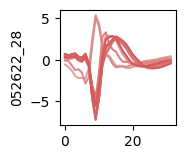

In [79]:
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import colorsys
from matplotlib.backends.backend_pdf import PdfPages

def generate_base_colors(n, saturation=0.6, lightness=0.5):
    hues = np.linspace(0, 1, n, endpoint=False)  
    base_colors = []
    for h in hues:
        rgb = colorsys.hls_to_rgb(h, lightness, saturation)
        base_colors.append(rgb)
    return base_colors

n_neurons = len(all_cluster_inf['Neuron'].unique())
base_palette = generate_base_colors(n_neurons) 


def get_gradient_palette(base_color, n_levels=16, reverse=False):
    palette = sns.light_palette(base_color, n_levels, reverse=reverse)
    return palette


with PdfPages('figure/cluster_view.pdf') as pdf:
    n_neurons = len(all_cluster_inf['Neuron'].unique())
    base_palette = generate_base_colors(n_neurons)
    
    for idx, neuron in enumerate(all_cluster_inf['Neuron'].unique()):
        temp = all_cluster_inf[all_cluster_inf['Neuron'] == neuron]
        
        current_base_color = base_palette[idx]
        line_palette = get_gradient_palette(current_base_color, n_levels=25, reverse=False)
        
        fig, ax = plt.subplots(figsize=(1.5, 1.5))
        for i in range(16):
            sns.lineplot(
                x=range(32),
                y=temp.iloc[i, 41:73],
                color=line_palette[i + 6],  
                ax=ax
            )
        
        ax.set_ylabel("Amplitude")
        ax.set_xticks([])
        ax.set_title(neuron)
        pdf.savefig(fig)
        plt.close(fig)

In [46]:
all_cluster_inf = all_cluster_inf[all_cluster_inf['Neuron'] != "Neuron_14"]
all_spike_inf = all_spike_inf[all_spike_inf['Neuron'] != "Neuron_14"]

In [47]:
all_cluster_inf.to_csv('/media/ubuntu/sda/data/filter_neuron/mouse_6/natural_image/cluster_inf.tsv', sep = '\t')
all_spike_inf.to_csv("/media/ubuntu/sda/data/filter_neuron/mouse_6/natural_image/spike_inf.tsv", sep='\t')

In [48]:
all_cluster_inf = pd.read_csv("cluster_inf.tsv", sep = '\t')

In [49]:
from matplotlib.backends.backend_pdf import PdfPages


In [50]:
with PdfPages('figure/waveform_channel.pdf') as pdf:
    for neuron in ['Neuron_1']:
        temp = all_cluster_inf[all_cluster_inf['Neuron'] == neuron]
        fig = plt.figure(figsize=(10, 10))
        fig.suptitle(neuron, y=1.02, fontsize=14)  
        all_waveforms = np.concatenate([wf for wf in temp['waveform']])
        ymin, ymax = np.min(all_waveforms), np.max(all_waveforms)
        base_color = '#898989'
        alpha_values = np.linspace(0.2, 1, 5)  
        for row_idx, (date, alpha) in enumerate(zip(["021322", "062422", "082322", "122022", "042323"], alpha_values)):
            for col_idx in range(6):
                ax = plt.subplot(5, 6, row_idx*6 + col_idx + 1)
                if not temp[temp['date'] == date].empty:
                    waveform = temp.loc[temp['date'] == date, 'waveform'].values[0][:, col_idx]
                    sns.lineplot(x=range(61), y=waveform, color=base_color, alpha=alpha, linewidth = 3)
                ax.set_ylim(ymin, ymax)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
    for neuron in ['Neuron_1']:
        temp = all_cluster_inf[all_cluster_inf['Neuron'] == neuron]
        fig = plt.figure(figsize=(10, 10))
        fig.suptitle(neuron, y=1.02, fontsize=14)  
        all_waveforms = np.concatenate([wf for wf in temp['waveform']])
        ymin, ymax = np.min(all_waveforms), np.max(all_waveforms)
        base_color = '#55A5DB'
        alpha_values = np.linspace(0.2, 1, 5)  
        for row_idx, (date, alpha) in enumerate(zip(["021322", "062422", "082322", "122022", "042323"], alpha_values)):
            for col_idx in range(6):
                ax = plt.subplot(5, 6, row_idx*6 + col_idx + 1)
                if not temp[temp['date'] == date].empty:
                    waveform = temp.loc[temp['date'] == date, 'waveform'].values[0][:, col_idx]
                    sns.lineplot(x=range(61), y=waveform, color=base_color, alpha=alpha, linewidth = 3)
                ax.set_ylim(ymin, ymax)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
    for neuron in ['Neuron_1']:
        temp = all_cluster_inf[all_cluster_inf['Neuron'] == neuron]
        fig = plt.figure(figsize=(10, 10))
        fig.suptitle(neuron, y=1.02, fontsize=14)  
        all_waveforms = np.concatenate([wf for wf in temp['waveform']])
        ymin, ymax = np.min(all_waveforms), np.max(all_waveforms)
        base_color = '#753589'
        alpha_values = np.linspace(0.2, 1, 5)  
        for row_idx, (date, alpha) in enumerate(zip(["021322", "062422", "082322", "122022", "042323"], alpha_values)):
            for col_idx in range(6):
                ax = plt.subplot(5, 6, row_idx*6 + col_idx + 1)
                if not temp[temp['date'] == date].empty:
                    waveform = temp.loc[temp['date'] == date, 'waveform'].values[0][:, col_idx]
                    sns.lineplot(x=range(61), y=waveform, color=base_color, alpha=alpha, linewidth = 3)
                ax.set_ylim(ymin, ymax)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()


ValueError: zero-dimensional arrays cannot be concatenated

<Figure size 1000x1000 with 0 Axes>